<a href="https://colab.research.google.com/github/mm6396/LungCancerCT/blob/main/CT05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Automatically crop the ROI*

In [42]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow


def crop_area_top(image_path):
   
    img = cv2.imread(image_path)

    cv2_imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

 
    ret, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

   
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key = cv2.contourArea)

    
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image using the coordinates of the bounding rectangle
    crop_img = img[y:y+h, x:x+w]

  
    if not os.path.exists('h2'):
        os.makedirs('h2')

    # Save the cropped image
    cv2.imwrite(os.path.join('h2', '10'+str(00)+'.tif'), crop_img)

    return crop_img



In [43]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def crop_area_XZ(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    max_area = 0
    largest_contour = None
    for contour in contours:
        contour_area = cv2.contourArea(contour)
        if contour_area > max_area:
            max_area = contour_area
            largest_contour = contour

    if largest_contour is None:
        print("No contour found.")
        return None

    # Draw the largest contour
    img_with_contour = cv2.drawContours(img.copy(), [largest_contour], -1, (0, 255, 0), 2)
    cv2_imshow(img_with_contour)

    # Crop the image around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    crop_img = img[y:y+h, x:x+w]

    if not os.path.exists('h2'):
        os.makedirs('h2')

    cv2.imwrite(os.path.join('h2', 'largest_contour.tif'), crop_img)

    return crop_img



In [44]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

def split_image(image_path, ratio):
    assert 0 <= ratio <= 1, "The split ratio must be a number between 0 and 1."
    
    img = cv2.imread(image_path)
    height, _, _ = img.shape

    # Calculate the split point based on the given ratio
    split_point = int(height * ratio)

    # Split the image
    upper_img = img[0:split_point, :]
    lower_img = img[split_point:, :]

    if not os.path.exists('h2'):
        os.makedirs('h2')

    if upper_img is not None and upper_img.size > 0:
        cv2.imwrite(os.path.join('h2', 'upper_part.tif'), upper_img)

    if lower_img is not None and lower_img.size > 0:
        cv2.imwrite(os.path.join('h2', 'lower_part.tif'), lower_img)

    return upper_img, lower_img



In [45]:
import cv2
import numpy as np

def calculate_red_area(image_path):
    # Load image
    img = cv2.imread(image_path)

    cv2_imshow(img)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define range for red color in HSV space
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    # Threshold the HSV image to get only red colors
    mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

   
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

   
    filled_mask = np.zeros_like(mask)

    total_area = 0
    # Calculate area for each contour
    for i in range(len(contours)):
        # Ignore inner contours (nested regions) # added to subtract the nested countours
        if hierarchy[0][i][3] != -1:
            continue

        area = cv2.contourArea(contours[i])
        total_area += area

     
        cv2.drawContours(filled_mask, contours, i, (255), thickness=cv2.FILLED)

   
    filled_img = cv2.bitwise_and(img, img, mask=filled_mask)

    # Calculate proportion of the total image area
    image_area = img.shape[0] * img.shape[1]
    proportion = total_area / image_area

    # Display filled image
    cv2.imshow('Filled Image', filled_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return hsv_img, proportion

 




Calculate the edge with *Canny*

In [46]:
import numpy as np
import cv2
import os

def calculate_area_canny(image_path):
    
    roi = cv2.imread(image_path)

   
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale ROI
    roi_blurred = cv2.GaussianBlur(roi_gray, (5, 5), 0)

    
    roi_edges = cv2.Canny(roi_blurred, 30, 100)

    # Perform a morphological closing operation to close small gaps in the contours
    kernel = np.ones((5,5), np.uint8)
    roi_edges_closed = cv2.morphologyEx(roi_edges, cv2.MORPH_CLOSE, kernel)

   
    contours, _ = cv2.findContours(roi_edges_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw the filled contours
    filled_roi = np.zeros_like(roi_edges)

    # Draw and fill the contours
    cv2.drawContours(filled_roi, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Count the number of white pixels (filled area)
    filled_area = np.count_nonzero(filled_roi)

    
    total_area = np.size(filled_roi)

    
    ratio = filled_area / total_area

    
    cv2_imshow(filled_roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return filled_roi, ratio


Calculate the area with red Border

In [48]:
import cv2
import numpy as np

def calculate_red_area(image_path):
  
    img = cv2.imread(image_path)

    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

   
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

   
    mask1 = cv2.inRange(hsv_img, lower_red, upper_red)
    mask2 = cv2.inRange(hsv_img, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    
    outer_contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   
    filled_mask = np.zeros_like(mask)

    
    total_area = 0
    for contour in outer_contours:
        area = cv2.contourArea(contour)
        total_area += area
        cv2.drawContours(filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

   
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, lower_white, upper_white)

  
    inner_contours, _ = cv2.findContours(white_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

 
    for contour in inner_contours:
        area = cv2.contourArea(contour)
        total_area -= area

    filled_img = cv2.bitwise_and(img, img, mask=filled_mask)

  
    image_area = img.shape[0] * img.shape[1]
    proportion = total_area / image_area

    
    cv2_imshow(filled_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return hsv_img, proportion

--------------------This is original image---------------------------

--------------------This is ROI---------------------------



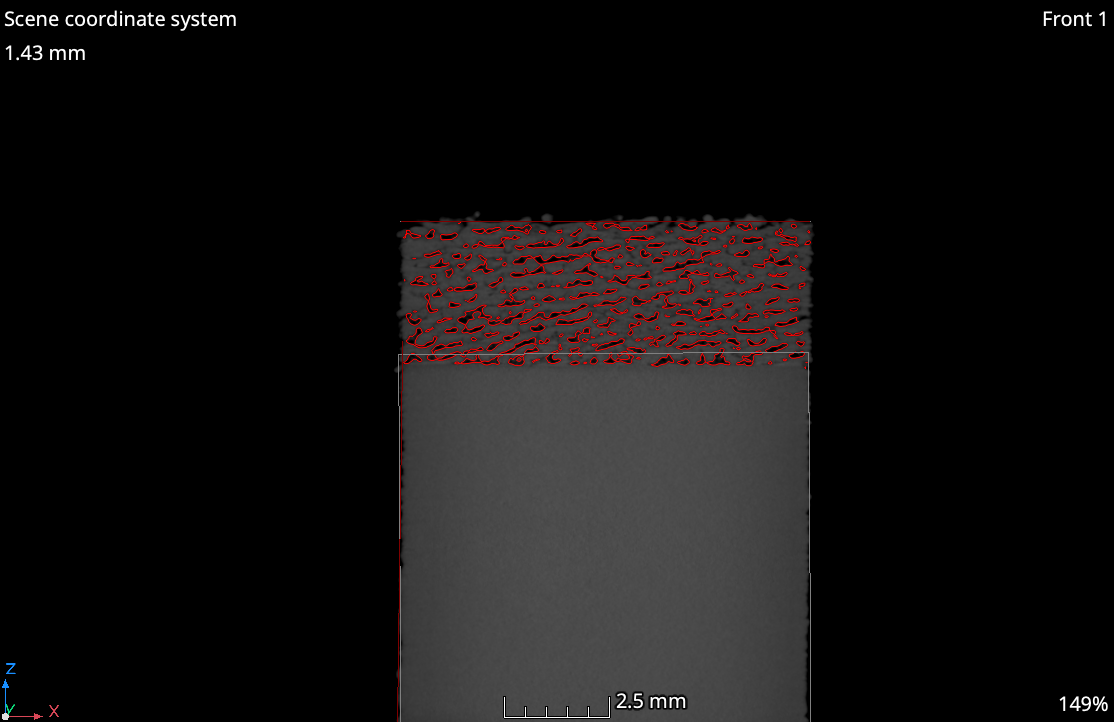

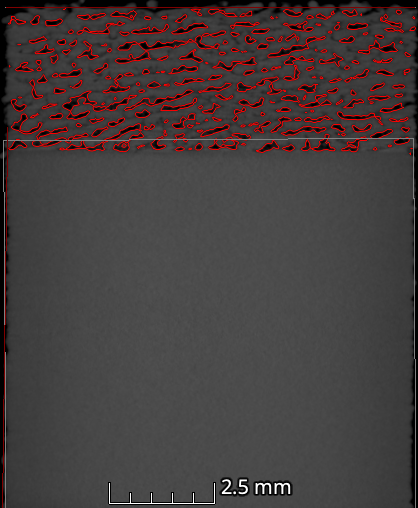

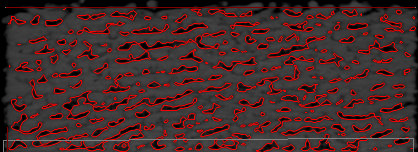

--------------------THE END ----
---------------------------inside Red area --------------------------


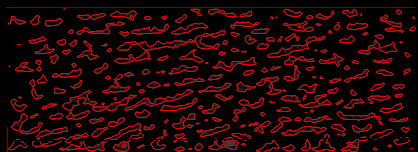

Proportion of the total image area: 
 {0.1896956056408965}


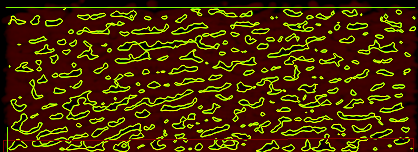

In [49]:
  print('--------------------This is original image---------------------------\n')
  #cv2_imshow('/content/sample01.tif')
  print('--------------------This is ROI---------------------------\n')
  roi = crop_area_top('/content/sample01.tif')
  upper_img , lower_img = split_image('/content/h2/100.tif' , 0.3)


  cv2_imshow(roi)
  cv2_imshow(upper_img)



  print('--------------------THE END ----')

  print('---------------------------inside Red area --------------------------')

  hsv_img , proportion = calculate_red_area('/content/h2/upper_part.tif')
 
  print('Proportion of the total image area: \n' , {proportion})

  cv2_imshow(hsv_img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

  cv2.destroyAllWindows()

Read the image from directory

In [50]:
import os

def read_images_in_directory(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.tif'):  
            full_path = os.path.join(directory_path, filename)
            if 'XY' in filename:
                full_path = os.path.join('/content/images', filename)
                roi = crop_area_top(full_path)
                
                
                if roi is not None:
                    cv2_imshow(roi)
                else:
                    print(f"Failed to process {full_path}")

                
                print('---------------------------Calculate inside the red border --------------------------')

                hsv_img , proportion = calculate_red_area('/content/h2/100.tif')
                print('Proportion of the total image area: \n' , {proportion})

                if hsv_img is not None:
                    cv2_imshow(hsv_img)
                else:
                    print(f"Failed to process {full_path}")

                cv2.destroyAllWindows()

            elif 'YZ' in filename or 'XZ' in filename:
                full_path = os.path.join('/content/images', filename)
                roi = crop_area_top(full_path)
                upper_img , lower_img = split_image('/content/h2/100.tif' , 0.3) # the ratio for each sample

                if roi is not None:
                    cv2_imshow(roi)
                else:
                    print(f"Failed to process {full_path}")

                if upper_img is not None:
                    cv2_imshow(upper_img)
                else:
                    print(f"Failed to process {full_path}")

                print('---------------------------Calculate inside the red border --------------------------')
                print('---------------------------inside Red area --------------------------')

                hsv_img , proportion = calculate_red_area('/content/h2/upper_part.tif')
                print('Proportion of the total image area: \n' , {proportion})

                if hsv_img is not None:
                    cv2_imshow(hsv_img)
                else:
                    print(f"Failed to process {full_path}")

                cv2.destroyAllWindows()

# Call the function with the path 
read_images_in_directory('/content/images')

FileNotFoundError: ignored

In [ ]:
!unzip /content/images.zip

Archive:  /content/images.zip
   creating: images/
  inflating: __MACOSX/._images       
  inflating: images/G2_FB_YZ_n3-00_2-00.tif  
  inflating: __MACOSX/images/._G2_FB_YZ_n3-00_2-00.tif  
  inflating: images/G2_FB_YZ_n2-00_3-00.tif  
  inflating: __MACOSX/images/._G2_FB_YZ_n2-00_3-00.tif  
  inflating: images/.DS_Store        
  inflating: __MACOSX/images/._.DS_Store  
  inflating: images/G2_FB_XY_n1-00_12-00.tif  
  inflating: __MACOSX/images/._G2_FB_XY_n1-00_12-00.tif  
  inflating: images/G2_FB_XZ_n4-00_1-00.tif  
  inflating: __MACOSX/images/._G2_FB_XZ_n4-00_1-00.tif  
  inflating: images/G2_FB_XY_n2-00_1-00.tif  
  inflating: __MACOSX/images/._G2_FB_XY_n2-00_1-00.tif  
  inflating: images/G2_FB_XZ_n2-00_3-00.tif  
  inflating: __MACOSX/images/._G2_FB_XZ_n2-00_3-00.tif  
  inflating: images/G2_FB_YZ_n4-00_1-00.tif  
  inflating: __MACOSX/images/._G2_FB_YZ_n4-00_1-00.tif  
  inflating: images/G2_FB_XZ_n3-00_2-00.tif  
  inflating: __MACOSX/images/._G2_FB_XZ_n3-00_2-00.tif  
  in

Calculalate some Quantities 

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def calculate_pixels_in_scale_bar(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape
    roi = image[int(height*0.85):, :]
    _, thresh = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)
    edges = cv2.Canny(thresh, 30, 100, apertureSize=3)
    plt.imshow(edges, cmap='gray')
    plt.show()
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=50, maxLineGap=5)
    if lines is None:
        print('No lines found')
    else:
        longest_line = max(lines, key=lambda line: line[0][2] - line[0][0])
        x1, y1, x2, y2 = longest_line[0]
        roi_vis = cv2.cvtColor(roi, cv2.COLOR_GRAY2RGB)
        cv2.line(roi_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        plt.imshow(roi_vis)
        plt.show()
        lengthpxl = x2 - x1
        print(f'Length of scale bar: {lengthpxl} pixels')
        return lengthpxl


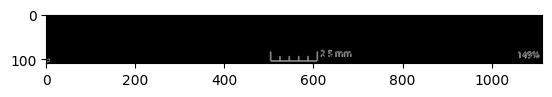

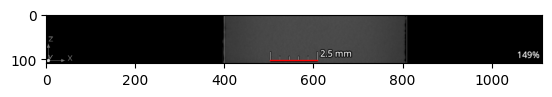

Length of scale bar: 107 pixels


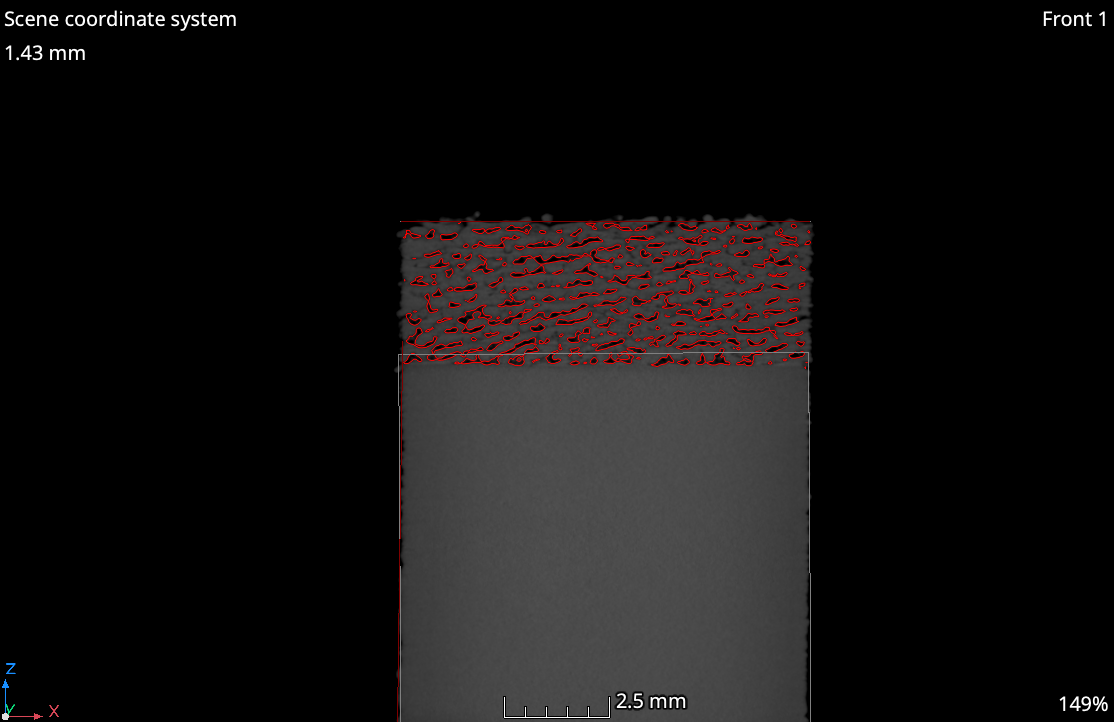

Area in square pixels: 2.0
Area in square microns: 3663.6799999999994


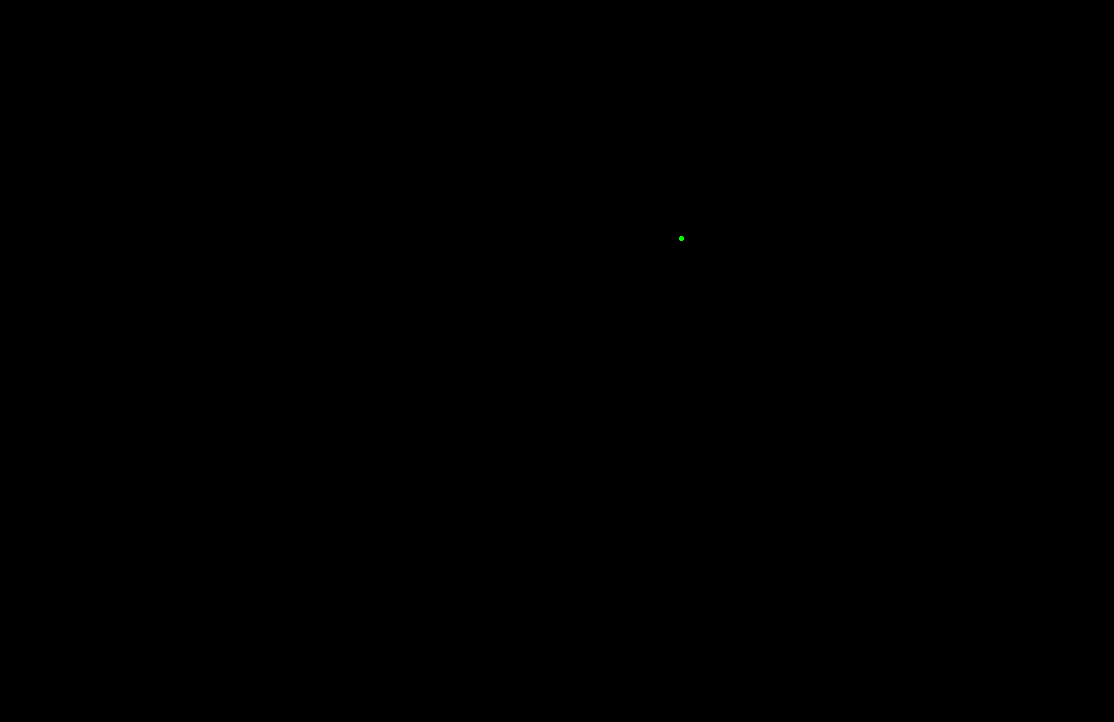

In [70]:
import cv2
import numpy as np
from shapely.geometry import Polygon
import random
from google.colab.patches import cv2_imshow

def random_countor_area_sm_sp(image_path, pixel_size):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at {image_path}")
        return

    
    cv2_imshow(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  
    lower_red = np.array([0, 50, 50])
    upper_red = np.array([10, 255, 255])

    
    mask = cv2.inRange(hsv, lower_red, upper_red)

   
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

   
    selected_contour = random.choice(contours)

    
    blank_image = np.zeros(image.shape, dtype=np.uint8)


    cv2.drawContours(blank_image, [selected_contour], -1, (0, 255, 0), 2)

   
    polygon = Polygon([point[0] for point in selected_contour])

   
    area_pixels = polygon.area
    print("Area in square pixels:", area_pixels)

    
    area_microns = area_pixels * (pixel_size ** 2)
    print("Area in square microns:", area_microns)

    
    cv2_imshow(blank_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


image_path0 = '/content/sample01.tif'



scale_bar_length = calculate_pixels_in_scale_bar(image_path0)
random_countor_area_sm_sp(image_path0, scale_bar_length / 2.5)


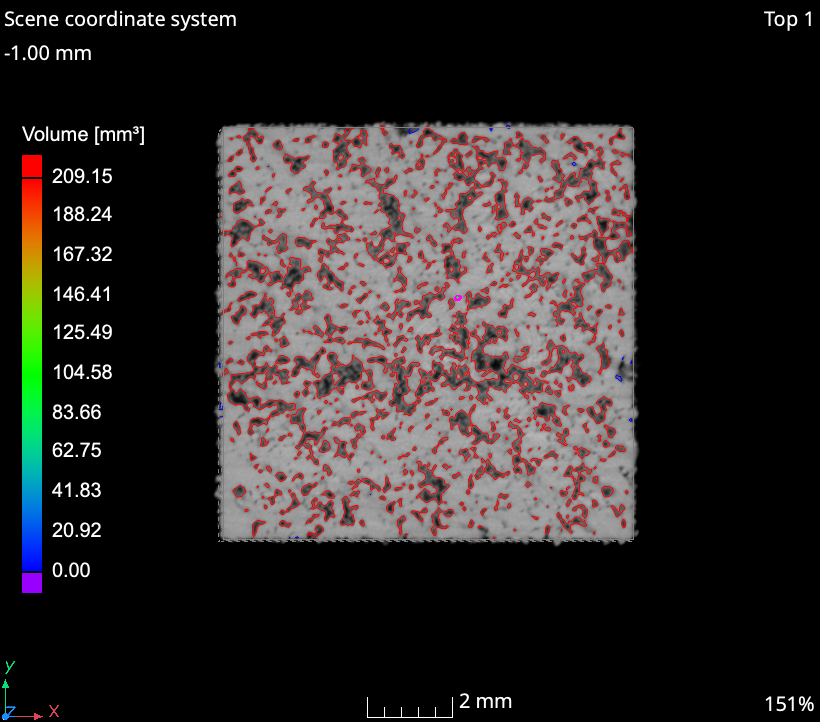

In [103]:
import cv2
import numpy as np
import random

def find_and_draw_centroid(image_path):
    
  
    img = cv2.imread(image_path)

    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])

   
    mask = cv2.inRange(hsv, lower_val, upper_val)

   
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    if not contours:
        print('No contours found')
        return None

   
    random_contour = random.choice(contours)

    
    M = cv2.moments(random_contour)

   
    centroid_x = int(M['m10'] / M['m00'])
    centroid_y = int(M['m01'] / M['m00'])

    
    cv2.drawContours(img, [random_contour], -1, (255, 0, 255), 2)

    
    cv2.circle(img, (centroid_x, centroid_y), 1, (0, 255, 0), -1)

   
    cv2_imshow( img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


find_and_draw_centroid('/content/sample02.tif')

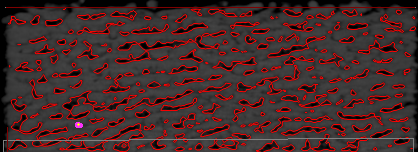

Center of mass (X, Y) is :  78.23529411764706 124.70588235294117


In [150]:
import cv2
import numpy as np
import random

def calculate_and_draw_center_of_mass(image_path):
    
    img = cv2.imread(image_path)

    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

   
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])

    
    mask = cv2.inRange(hsv, lower_val, upper_val)

   
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    if not contours:
        print('No contours found')
        return None

    
    random_contour = random.choice(contours)

    
    contour_mask = np.zeros_like(mask)
    cv2.drawContours(contour_mask, [random_contour], -1, (255), thickness=cv2.FILLED)

    
    cv2.drawContours(img, [random_contour], -1, (250, 50, 250), 2)

    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    total_brightness = np.sum(gray_img[contour_mask == 255])

    
    height, width = gray_img.shape

   
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

   
    center_of_mass_x = np.sum(x_coords[contour_mask == 255] * gray_img[contour_mask == 255]) / total_brightness
    center_of_mass_y = np.sum(y_coords[contour_mask == 255] * gray_img[contour_mask == 255]) / total_brightness

    
    cv2.circle(img, (int(center_of_mass_x), int(center_of_mass_y)), 1, (0, 255, 255), -1)

   
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return center_of_mass_x, center_of_mass_y


center_of_mass_x , center_of_mass_y = calculate_and_draw_center_of_mass('/content/h2/upper_part.tif')
print('Center of mass (X, Y) is : ' , center_of_mass_x , center_of_mass_y)

The perimeter of the selected contour is: 144.2670258283615 pixels


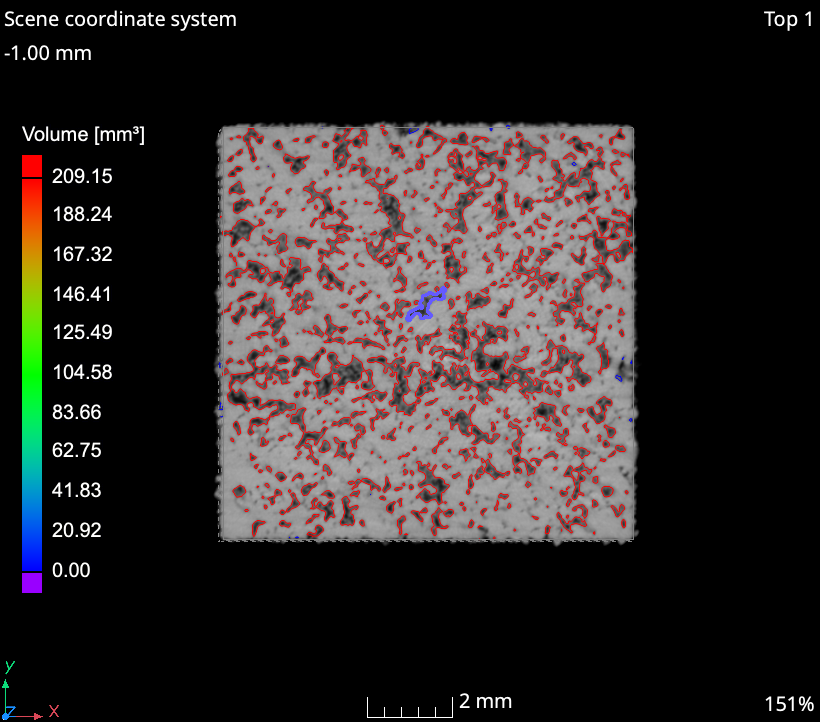

 Primeter is  :  144.2670258283615


In [161]:
import cv2
import numpy as np
import random

def calculate_and_draw_perimeter(image_path):
   
    img = cv2.imread(image_path)

    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])

   
    mask = cv2.inRange(hsv, lower_val, upper_val)

    
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

   
    if not contours:
        print('No contours found')
        return None

    
    random_contour = random.choice(contours)

   
    perimeter = cv2.arcLength(random_contour, True)

    print(f'The perimeter of the selected contour is: {perimeter} pixels')

    
    cv2.drawContours(img, [random_contour], -1, (255, 90, 100), 2)

   
    cv2_imshow( img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return perimeter


perimeter = calculate_and_draw_perimeter('/content/sample02.tif')
print(" Primeter is  : " , perimeter)

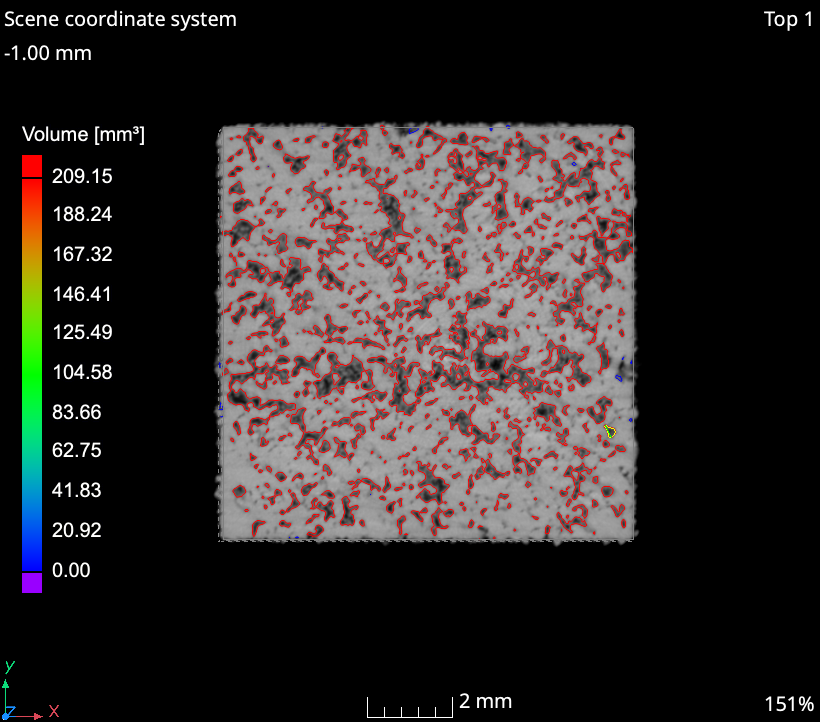

The Feret diameter of the selected contour is: 13.416407864998739 pixels


In [274]:
import cv2
import numpy as np
import random
from scipy.spatial import distance

def calculate_and_draw_feret_diameter(image_path):
    
    img = cv2.imread(image_path)

   
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

   
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])

    
    mask = cv2.inRange(hsv, lower_val, upper_val)

   
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    if not contours:
        print('No contours found')
        return None

   
    random_contour = random.choice(contours)

    
    random_contour = np.squeeze(random_contour)

    
    distances = distance.cdist(random_contour, random_contour, 'euclidean')
    feret_diameter = np.max(distances)
    index_1, index_2 = np.unravel_index(distances.argmax(), distances.shape)

    

    
    cv2.drawContours(img, [random_contour], -1, (0, 2550 , 250), 1)

    
    cv2.line(img, tuple(random_contour[index_1]), tuple(random_contour[index_2]), (0, 255, 0), 1)

    
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return feret_diameter

feret_diameter = calculate_and_draw_feret_diameter('/content/sample02.tif')
print(f'The Feret diameter of the selected contour is: {feret_diameter} pixels')

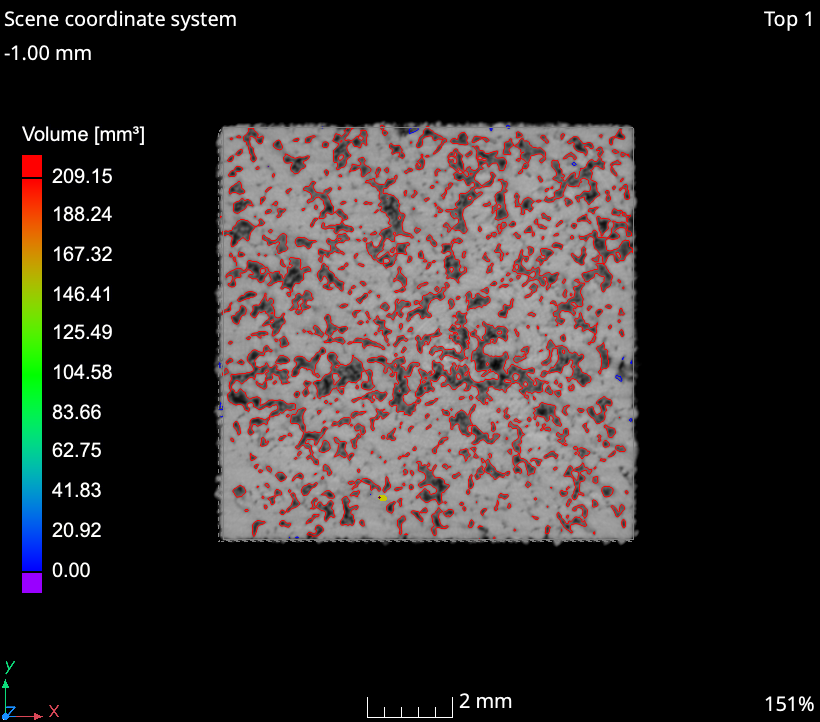

The minimum Feret diameter of the selected contour is: 1.4142135623730951 pixels


In [289]:
import cv2
import numpy as np
import random
from scipy.spatial import distance

def calculate_and_draw_min_feret_diameter(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)
    random_contour = np.squeeze(random_contour)

    distances = distance.cdist(random_contour, random_contour, 'euclidean')
    min_feret_diameter = np.min(distances[np.triu_indices(distances.shape[0], k=1)])
    index_1, index_2 = np.unravel_index(distances.argmin(), distances.shape)

    cv2.drawContours(img, [random_contour], -1, (0, 200, 200), 2)

    # Draw the minimum feret diameter line
    cv2.line(img, tuple(random_contour[index_1]), tuple(random_contour[index_2]), (80, 0, 100), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return min_feret_diameter

min_feret_diameter = calculate_and_draw_min_feret_diameter('/content/sample02.tif')
print(f'The minimum Feret diameter of the selected contour is: {min_feret_diameter} pixels')

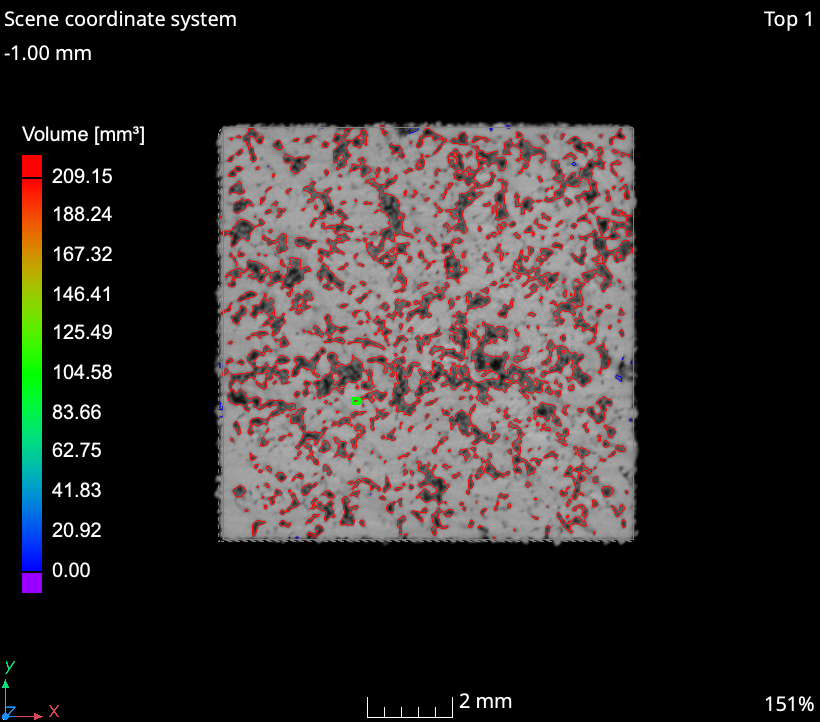

The x coordinate of the upper left corner of the bounding rectangle is: 352 pixels
The y coordinate of the upper left corner of the bounding rectangle is: 398 pixels


In [291]:
import cv2
import numpy as np
import random

def calculate_and_draw_bounding_rectangle(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    # calculate bounding rectangle
    x, y, w, h = cv2.boundingRect(random_contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return x, y

bx, by = calculate_and_draw_bounding_rectangle('/content/sample02.tif')
print(f'The x coordinate of the upper left corner of the bounding rectangle is: {bx} pixels')
print(f'The y coordinate of the upper left corner of the bounding rectangle is: {by} pixels')

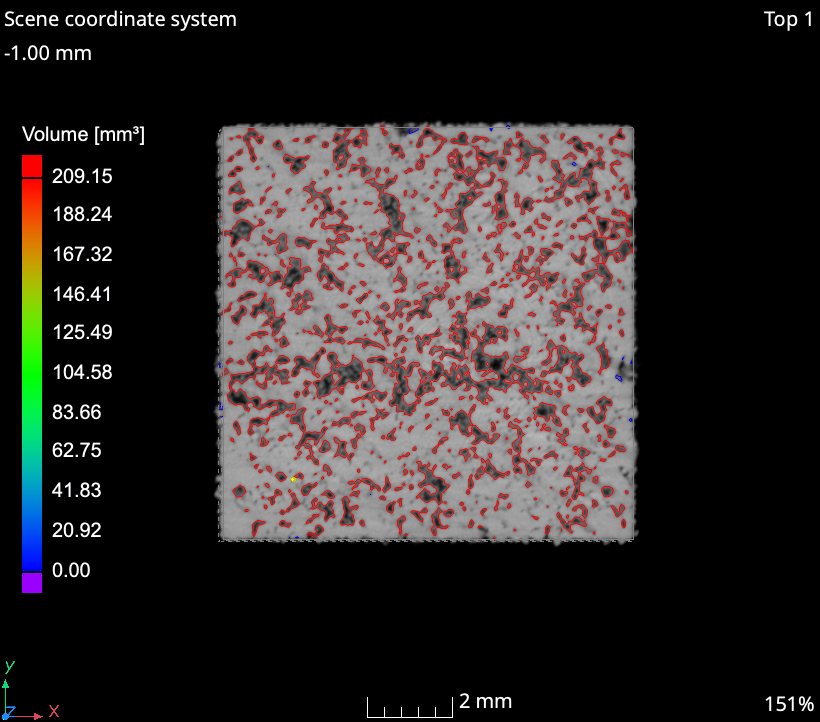

The minimum Feret diameter of the selected contour is: 1.4142135623730951 pixels
The x coordinate of the starting point of the minimum Feret diameter is: 292
The y coordinate of the starting point of the minimum Feret diameter is: 479


In [334]:
import cv2
import numpy as np
import random
from scipy.spatial import distance

def calculate_and_draw_min_feret_diameter(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)
    random_contour = np.squeeze(random_contour)

    distances = distance.cdist(random_contour, random_contour, 'euclidean')
    min_feret_diameter = np.min(distances[np.triu_indices(distances.shape[0], k=1)])
    index_1, index_2 = np.unravel_index(distances.argmin(), distances.shape)

    cv2.drawContours(img, [random_contour], -1, (0, 200, 200), 2)
    cv2.line(img, tuple(random_contour[index_1]), tuple(random_contour[index_2]), (0, 255, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return min_feret_diameter, random_contour[index_1][0], random_contour[index_1][1]

min_feret_diameter, feret_x, feret_y = calculate_and_draw_min_feret_diameter('/content/sample02.tif')
print(f'The minimum Feret diameter of the selected contour is: {min_feret_diameter} pixels')
print(f'The x coordinate of the starting point of the minimum Feret diameter is: {feret_x}')
print(f'The y coordinate of the starting point of the minimum Feret diameter is: {feret_y}')


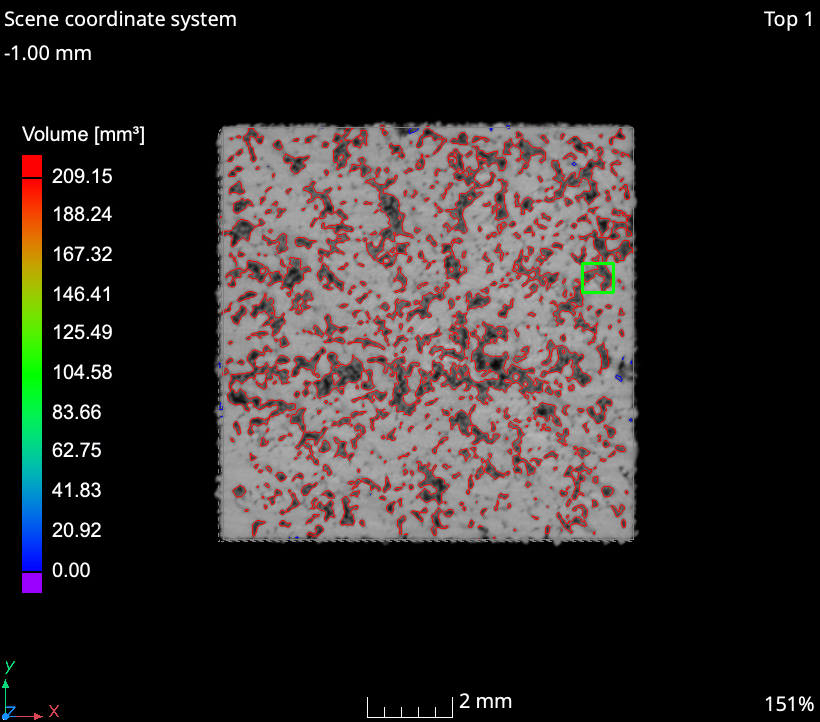

The width of the bounding rectangle is: 31 pixels
The height of the bounding rectangle is: 29 pixels
The ratio of height to width is: 0.9354838709677419


In [346]:
import cv2
import numpy as np
import random

def calculate_and_draw_bounding_rectangle(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    # calculate bounding rectangle
    x, y, w, h = cv2.boundingRect(random_contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # calculate height-to-width ratio
    ratio = h / w

    return w, h, ratio

width, height, ratio = calculate_and_draw_bounding_rectangle('/content/sample02.tif')
print(f'The width of the bounding rectangle is: {width} pixels')
print(f'The height of the bounding rectangle is: {height} pixels')
print(f'The ratio of height to width is: {ratio}')

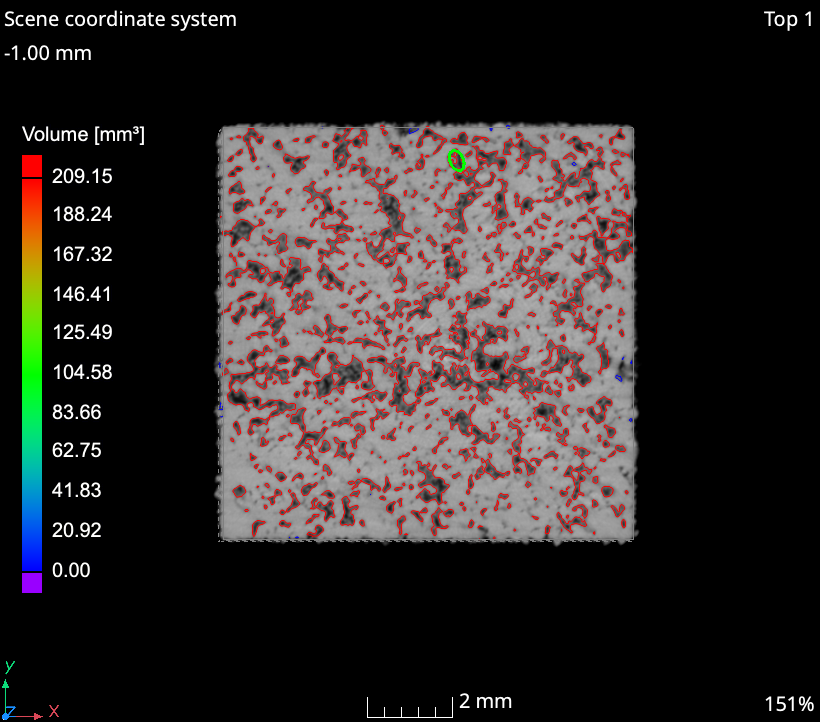

The major axis of the ellipse is: 21.034015655517578 pixels
The minor axis of the ellipse is: 13.534737586975098 pixels
The angle of the ellipse is: 155.76051330566406 degrees


In [350]:
import cv2
import numpy as np
import random

def calculate_and_draw_fit_ellipse(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    # Fit ellipse
    ellipse = cv2.fitEllipse(random_contour)
    cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # The output 'ellipse' is ((xc, yc), (a, b), theta)
    center, axes, angle = ellipse
    major_axis = max(axes)
    minor_axis = min(axes)

    return major_axis, minor_axis, angle

major_axis, minor_axis, angle = calculate_and_draw_fit_ellipse('/content/sample02.tif')
print(f'The major axis of the ellipse is: {major_axis} pixels')
print(f'The minor axis of the ellipse is: {minor_axis} pixels')
print(f'The angle of the ellipse is: {angle} degrees')

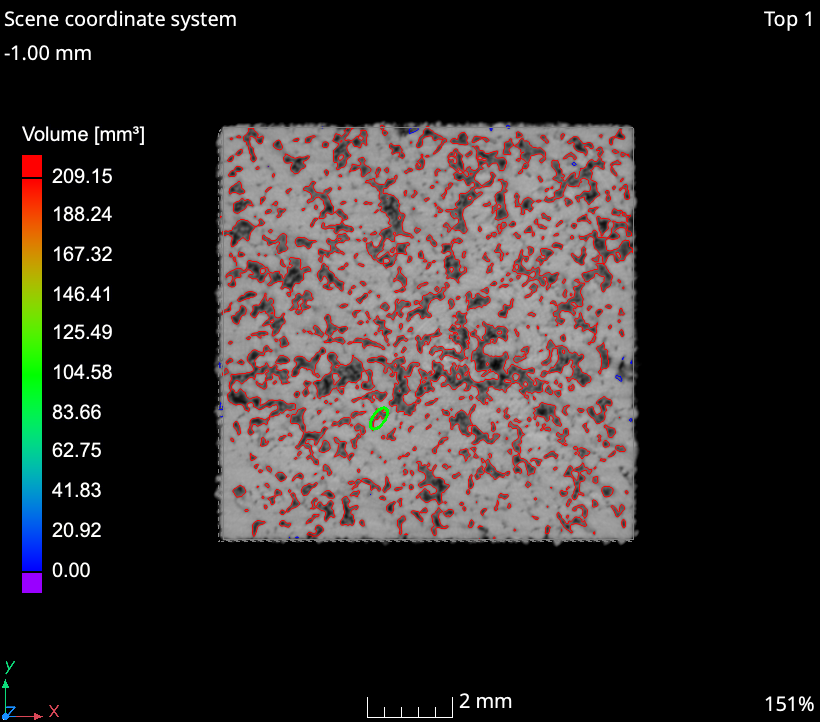

The x-coordinate of the ellipse centroid is: 378.36395263671875 pixels
The y-coordinate of the ellipse centroid is: 418.04754638671875 pixels


In [353]:
import cv2
import numpy as np
import random

def calculate_and_draw_fit_ellipse(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours with fewer than 5 points
    valid_contours = [cnt for cnt in contours if len(cnt) >= 5]

    if not valid_contours:
        print('No valid contours found')
        return None

    random_contour = random.choice(valid_contours)

    # Fit ellipse
    ellipse = cv2.fitEllipse(random_contour)
    cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # The output 'ellipse' is ((xc, yc), (a, b), theta)
    center, _, _ = ellipse
    centroid_x, centroid_y = center

    return centroid_x, centroid_y

centroid_x, centroid_y = calculate_and_draw_fit_ellipse('/content/sample02.tif')
print(f'The x-coordinate of the ellipse centroid is: {centroid_x} pixels')
print(f'The y-coordinate of the ellipse centroid is: {centroid_y} pixels')

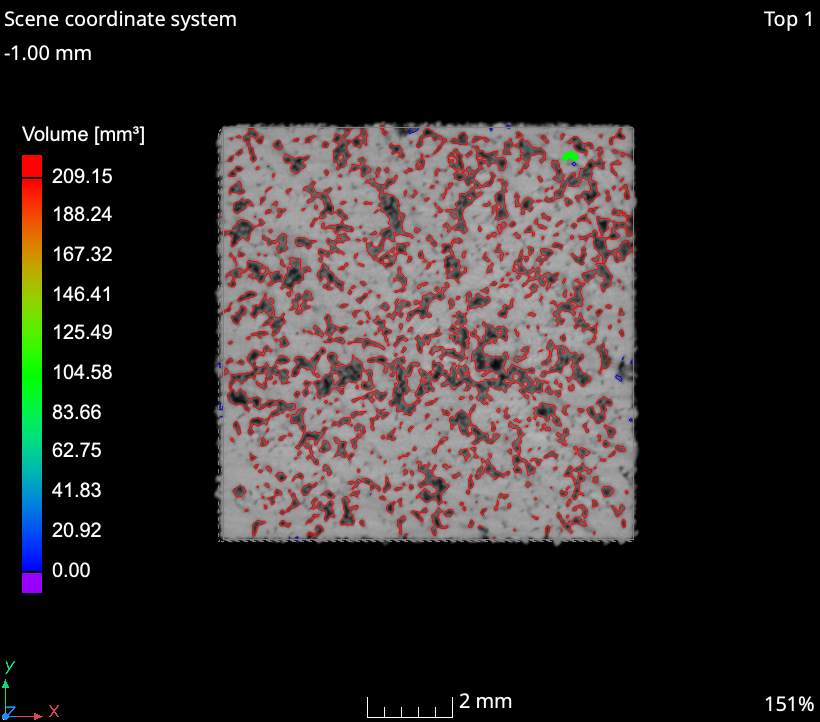

The circularity of the selected contour is: 0.43087879546594854


In [366]:
import cv2
import numpy as np
import random
import math

def calculate_and_draw_circularity(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    # Calculate area and perimeter of the contour
    area = cv2.contourArea(random_contour)
    perimeter = cv2.arcLength(random_contour, True)

    # Calculate circularity
    circularity = (4 * math.pi * area) / (perimeter ** 2)

    # Draw contour on the image
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)

    # Show the image with contour
    cv2_imshow( img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return circularity

circularity = calculate_and_draw_circularity('/content/sample02.tif')
print(f'The circularity of the selected contour is: {circularity}')

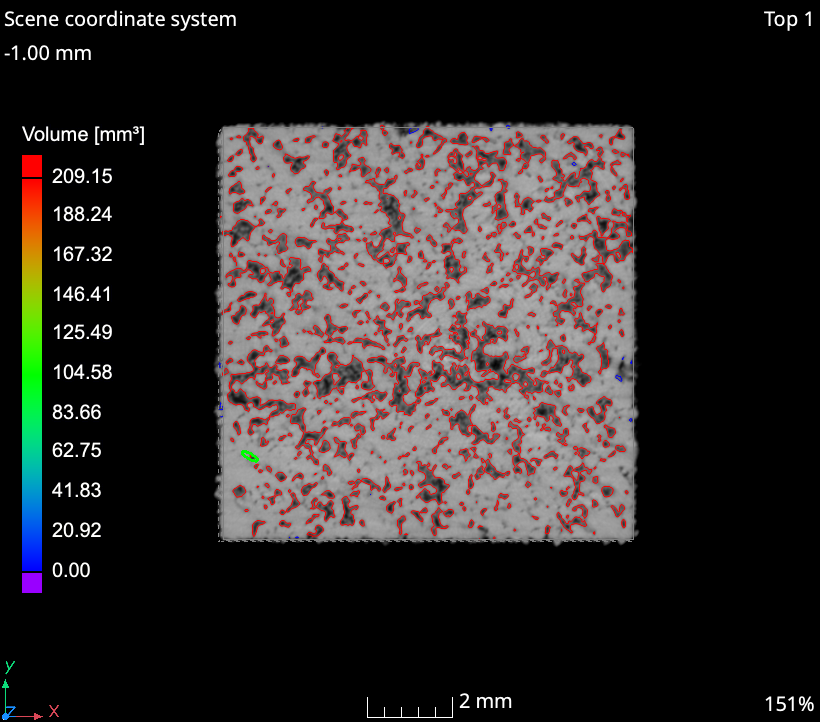

The aspect ratio of the selected contour is: 3.0972083482566597


In [369]:
import cv2
import numpy as np
import random

def calculate_and_draw_aspect_ratio(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

   
    valid_contours = [cnt for cnt in contours if len(cnt) >= 5]

    if not valid_contours:
        print('No valid contours found')
        return None

    random_contour = random.choice(valid_contours)

    
    ellipse = cv2.fitEllipse(random_contour)
    cv2.ellipse(img, ellipse, (0, 255, 0), 2)

   
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    
    _, axes, _ = ellipse
    major_axis, minor_axis = max(axes), min(axes)

  
    aspect_ratio = major_axis / minor_axis

    return aspect_ratio

aspect_ratio = calculate_and_draw_aspect_ratio('/content/sample02.tif')
print(f'The aspect ratio of the selected contour is: {aspect_ratio}')

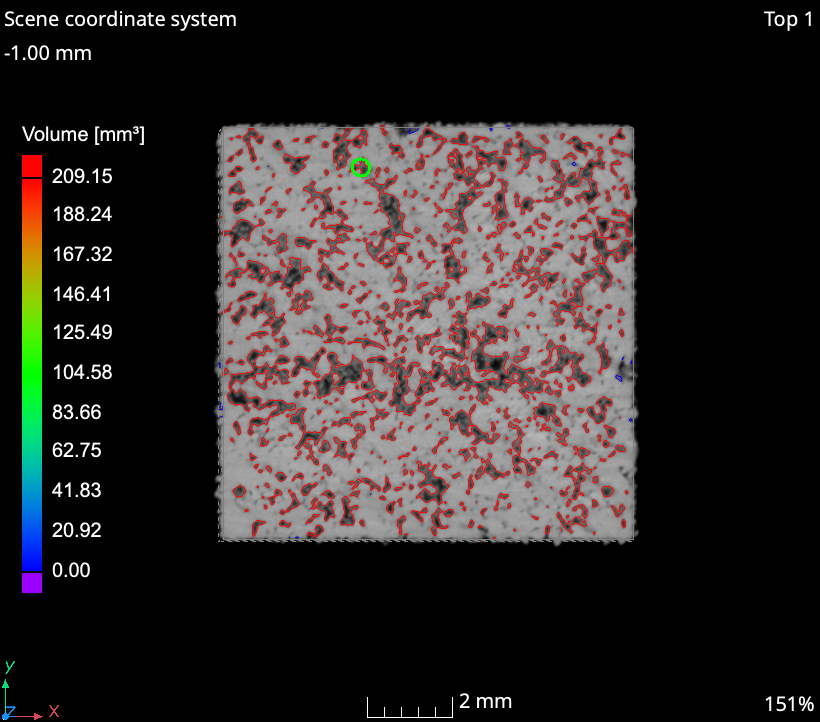

The roundness of the selected contour is: 0.5683586196026097


In [372]:
import cv2
import numpy as np
import random
import math

def calculate_and_draw_roundness(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

   
    valid_contours = [cnt for cnt in contours if len(cnt) >= 5]

    if not valid_contours:
        print('No valid contours found')
        return None

    random_contour = random.choice(valid_contours)

   
    ellipse = cv2.fitEllipse(random_contour)
    cv2.ellipse(img, ellipse, (0, 255, 0), 2)

   
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    _, axes, _ = ellipse
    major_axis = max(axes)

    # Calculate contour area
    area = cv2.contourArea(random_contour)

    # Calculate roundness
    roundness = 4 * area / (math.pi * major_axis ** 2)

    return roundness

roundness = calculate_and_draw_roundness('/content/sample02.tif')
print(f'The roundness of the selected contour is: {roundness}')

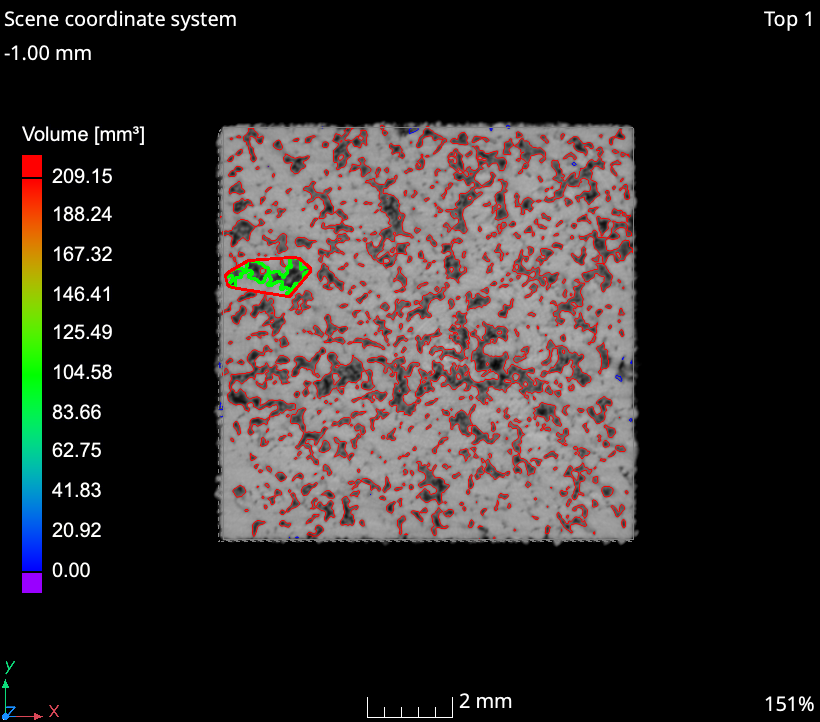

The solidity of the selected contour is: 0.47551709582102153


In [379]:
import cv2
import numpy as np
import random

def calculate_solidity(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    
    area = cv2.contourArea(random_contour)

    
    hull = cv2.convexHull(random_contour)
    hull_area = cv2.contourArea(hull)

    
    solidity = float(area)/hull_area

  
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(img, [hull], -1, (0, 0, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return solidity

solidity = calculate_solidity('/content/sample02.tif')
print(f'The solidity of the selected contour is: {solidity}')

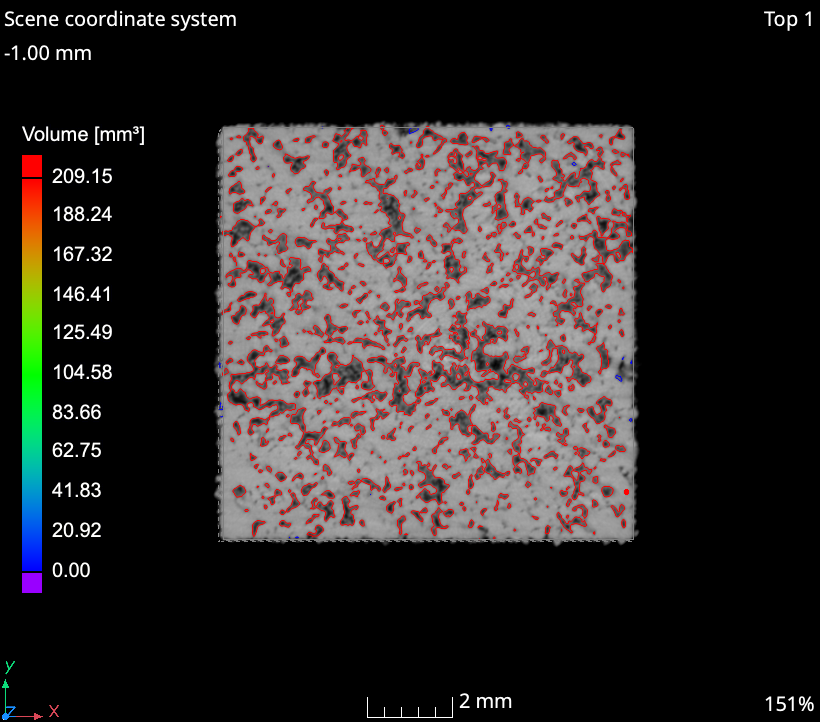

The roughness of the selected contour is: 1.0


In [385]:
import cv2
import numpy as np
import random

def calculate_and_draw_roughness(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    
    contour_perimeter = cv2.arcLength(random_contour, True)

   
    hull = cv2.convexHull(random_contour)
    hull_perimeter = cv2.arcLength(hull, True)

   
    roughness = hull_perimeter / contour_perimeter

    
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(img, [hull], -1, (0, 0, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return roughness

roughness = calculate_and_draw_roughness('/content/sample02.tif')
print(f'The roughness of the selected contour is: {roughness}')

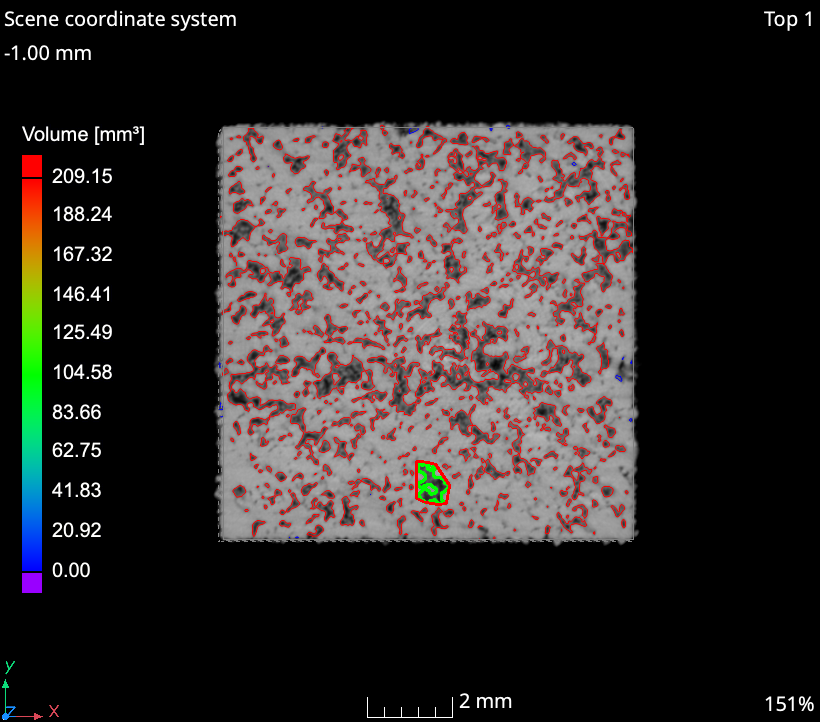

The shape factor of the selected contour is: 0.49188220671084437


In [395]:
import cv2
import numpy as np
import random
import math

def calculate_and_draw_shape_factor(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    
    contour_area = cv2.contourArea(random_contour)

   
    hull = cv2.convexHull(random_contour)
    hull_perimeter = cv2.arcLength(hull, True)

    
    shape_factor = 4*math.pi*contour_area / (hull_perimeter ** 2)

   
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(img, [hull], -1, (0, 0, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return shape_factor

shape_factor = calculate_and_draw_shape_factor('/content/sample02.tif')
print(f'The shape factor of the selected contour is: {shape_factor}')

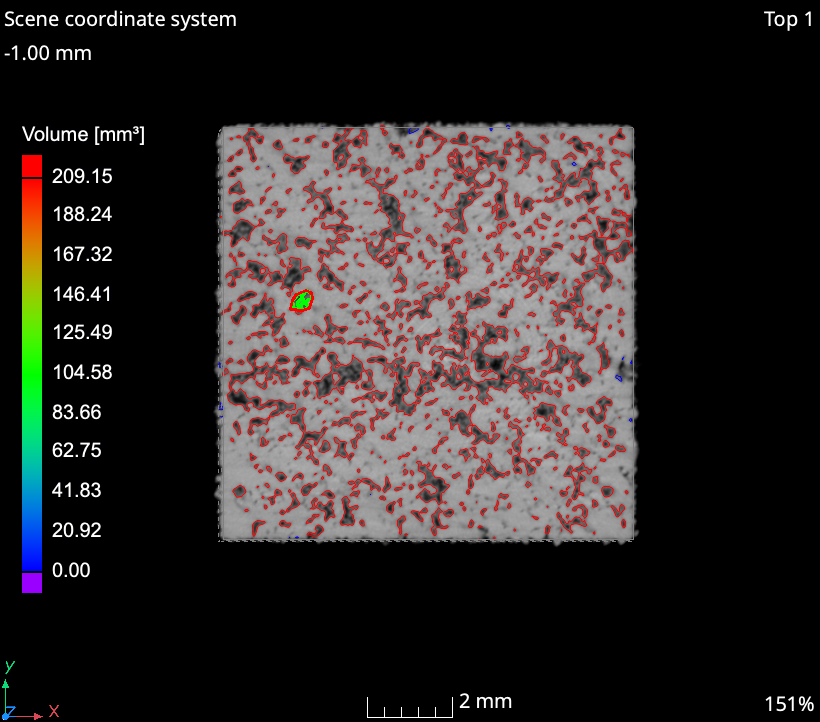

The convexity of the selected contour is: 0.65086887835703


In [397]:
import cv2
import numpy as np
import random

def calculate_and_draw_convexity(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

    contour_area = cv2.contourArea(random_contour)

   
    hull = cv2.convexHull(random_contour)
    hull_area = cv2.contourArea(hull)

    convexity = contour_area / hull_area

    
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(img, [hull], -1, (0, 0, 255), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return convexity

convexity = calculate_and_draw_convexity('/content/sample02.tif')
print(f'The convexity of the selected contour is: {convexity}')

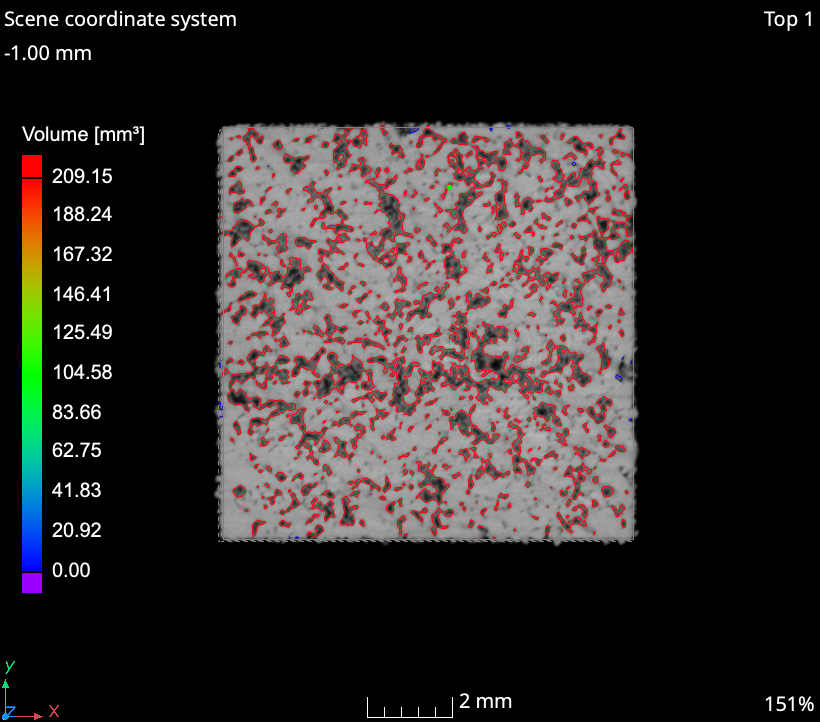

The Perimeter to Area Ratio of the selected contour is: 2.8284270763397217


In [399]:
import cv2
import numpy as np
import random

def calculate_perimeter_to_area_ratio(image_path):
    
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_val = np.array([0, 100, 100])
    upper_val = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_val, upper_val)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print('No contours found')
        return None

    random_contour = random.choice(contours)

   
    contour_area = cv2.contourArea(random_contour)

   
    contour_perimeter = cv2.arcLength(random_contour, True)

    
    perimeter_to_area_ratio = contour_perimeter / contour_area

    
    cv2.drawContours(img, [random_contour], -1, (0, 255, 0), 2)

    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return perimeter_to_area_ratio

perimeter_to_area_ratio = calculate_perimeter_to_area_ratio('/content/sample02.tif')
print(f'The Perimeter to Area Ratio of the selected contour is: {perimeter_to_area_ratio}')